## NLP 2021 - CA4

-- Sajjad Pakdaman Savoji (810195517)

# import libs

In [ ]:
!pip install transformers
!pip3 install nltk
!pip install tweet-preprocessor
!pip3 install contractions

In [ ]:
import re
import nltk
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
import preprocessor as p
import copy
import contractions 
from tqdm.notebook import tqdm

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# specify GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

# read data

In [ ]:
df_train = pd.read_csv("train.csv")
df_train.head()
print(df_train.shape)
df_train['label'].value_counts(normalize = True)

(10000, 2)


0    0.579
1    0.421
Name: label, dtype: float64

In [ ]:
df_test = pd.read_csv("test.csv")
df_test.head()
print(df_test.shape)
df_test['label'].value_counts(normalize = True)

(3000, 2)


0    0.58
1    0.42
Name: label, dtype: float64

# preprocessing data

In [ ]:
def expand_contractions(tweet):
    return contractions.fix(tweet)

def and_fixer(tweet):
    return re.sub(r"&", " and ", tweet)

def punch_fixer(tweet):
    tweet = re.sub(r"(\.|;|:)+", ".", tweet)
    tweet = re.sub(r"\.+", " .", tweet)
    tweet = re.sub(r"\?", " ? ", tweet)
    tweet = re.sub(r"\!", " ! ", tweet)
    return tweet

def seperator_fixer(tweet):
    return re.sub(r"(\$|,|/|<|>|=|\+|%|\n|\'|\")+", " ", tweet)

def line_fixer(tweet):
    return re.sub(r"(-|_)+", " ", tweet)

def number_fixer(tweet):
    return re.sub(r"[0-9]+", " ", tweet)

def space_fixer(tweet):
    return re.sub(r" +", " ", tweet)

def single_alph_fixer(tweet):
    return re.sub(r" [A-Za-z] ", "", tweet)

def costum_preprocessing(tweet):
    tweet = expand_contractions(tweet)
    tweet = p.clean(tweet)
    tweet = and_fixer(tweet)
    tweet = punch_fixer(tweet)
    tweet = line_fixer(tweet)
    tweet = number_fixer(tweet)
    tweet = seperator_fixer(tweet)
    tweet = space_fixer(tweet)
    tweet = single_alph_fixer(tweet)
    return tweet

In [ ]:
df_train.text = df_train.text.apply(costum_preprocessing)
df_test.text  = df_test.text.apply(costum_preprocessing)

# BERT

In [ ]:
train_text   = np.array(df_train.text)
train_labels = np.array(df_train.label)
test_text    = np.array(df_test.text)
test_labels  = np.array(df_test.label)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


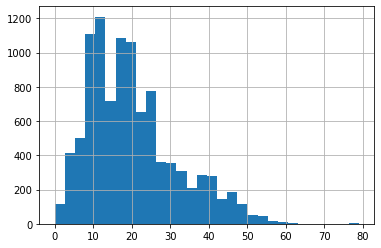

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 50

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [ ]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      bert_out = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(bert_out.pooler_output)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-4)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.86355786 1.18764846]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [ ]:
def predict_loader(loader):
    pred_list  = []
    label_list = []
    for step,batch in enumerate(loader):    
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        pred_list += [model(seq, mask).detach().cpu().numpy()]
        label_list += [labels.detach().cpu().numpy()]

    labels = np.concatenate(label_list)
    preds = np.concatenate(pred_list)
    preds = np.argmax(preds, axis = 1)
    return labels, preds

In [ ]:
def report(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1s = f1_score(y_true, y_pred)
    return [acc, pre, rec, f1s]

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # # progress update after every 50 batches.
    # if step % 50 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # # Progress update every 50 batches.
    # if step % 50 == 0 and not step == 0:
      
    #   # Calculate elapsed time in minutes.
    # #   elapsed = format_time(time.time() - t0)
            
    #   # Report progress.
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
train_metrics=[]
valid_metrics=[]
with torch.no_grad():
    train_metrics.append(report(*predict_loader(train_dataloader)))
    valid_metrics.append(report(*predict_loader(val_dataloader)))

In [ ]:
# number of training epochs
epochs = 10

In [ ]:
#for each epoch
for epoch in tqdm(range(epochs), desc='epochs'):
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # add metrics
    with torch.no_grad():
        train_metrics.append(report(*predict_loader(train_dataloader)))
        valid_metrics.append(report(*predict_loader(val_dataloader)))
        
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


Evaluating...

Training Loss: 0.593
Validation Loss: 0.767

Evaluating...

Training Loss: 0.586
Validation Loss: 0.780

Evaluating...

Training Loss: 0.587
Validation Loss: 0.777

Evaluating...

Training Loss: 0.593
Validation Loss: 0.670

Evaluating...

Training Loss: 0.590
Validation Loss: 0.800

Evaluating...

Training Loss: 0.592
Validation Loss: 0.654

Evaluating...

Training Loss: 0.584
Validation Loss: 0.757

Evaluating...

Training Loss: 0.583
Validation Loss: 0.741

Evaluating...

Training Loss: 0.583
Validation Loss: 0.687

Evaluating...

Training Loss: 0.581
Validation Loss: 0.975



In [ ]:
epochs = 20

Text(0.5, 1.0, 'Cross Entropy Loss in Training')

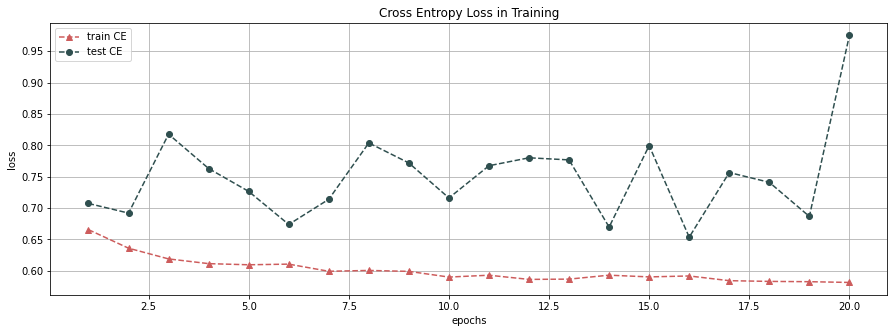

In [ ]:
plt.figure(figsize=(15, 5))
x = np.linspace(1, epochs, len(train_losses))
plt.plot(x, train_losses, label='train CE', color='indianred', marker='^', linestyle='--')
x = np.linspace(1, epochs, len(valid_losses))
plt.plot(x, valid_losses, label='test CE', color='darkslategray', marker='o', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.title('Cross Entropy Loss in Training')

# plt.figure(figsize=(15, 5))
# x = np.linspace(1, epochs, len(valid_losses))
# plt.plot(x, valid_losses, label='test CE', color='darkslategray', marker='o', linestyle='--')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.grid()
# plt.title('Cross Entropy Loss in Training')


Text(0.5, 1.0, 'Classification Metrics for Training Set')

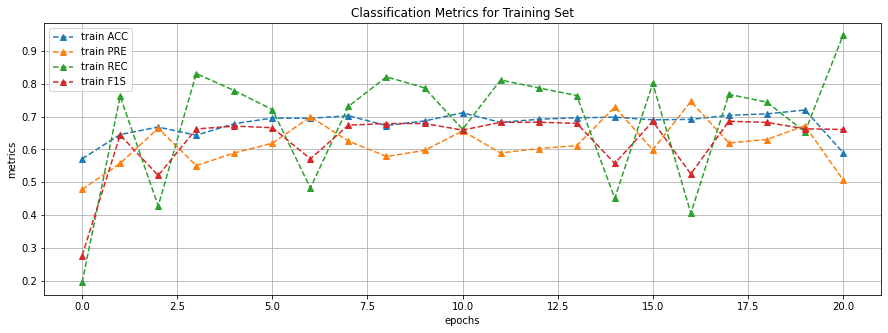

In [ ]:
plt.figure(figsize=(15, 5))
x = np.linspace(0, epochs, len(train_metrics))
accs = [i[0] for i in train_metrics]
prec = [i[1] for i in train_metrics]
recs = [i[2] for i in train_metrics]
f1s  = [i[3] for i in train_metrics]
plt.plot(x, accs, label='train ACC', marker='^', linestyle='--')
plt.plot(x, prec, label='train PRE', marker='^', linestyle='--')
plt.plot(x, recs, label='train REC', marker='^', linestyle='--')
plt.plot(x, f1s , label='train F1S', marker='^', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('metrics')
plt.legend()
plt.grid()
plt.title('Classification Metrics for Training Set')

Text(0.5, 1.0, 'Classification Metrics for Testing Set')

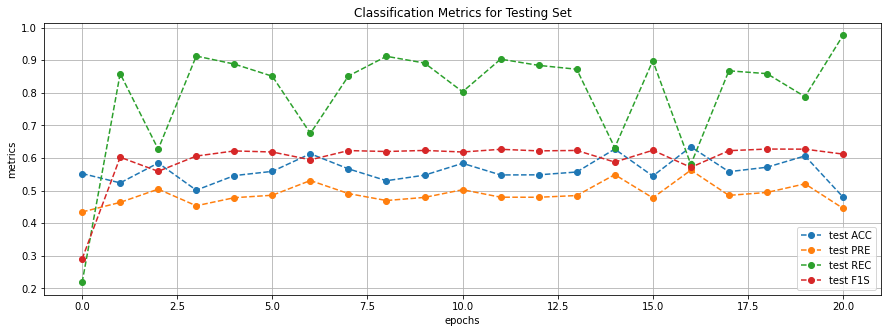

In [ ]:
plt.figure(figsize=(15, 5))
x = np.linspace(0, epochs, len(valid_metrics))
accs = [i[0] for i in valid_metrics]
prec = [i[1] for i in valid_metrics]
recs = [i[2] for i in valid_metrics]
f1s  = [i[3] for i in valid_metrics]
plt.plot(x, accs, label='test ACC', marker='o', linestyle='--')
plt.plot(x, prec, label='test PRE', marker='o', linestyle='--')
plt.plot(x, recs, label='test REC', marker='o', linestyle='--')
plt.plot(x, f1s , label='test F1S', marker='o', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('metrics')
plt.legend()
plt.grid()
plt.title('Classification Metrics for Testing Set')

In [ ]:
print(accs[-1], prec[-1], recs[-1], f1s[-1])

0.48 0.44565217391304346 0.9761904761904762 0.6119402985074626


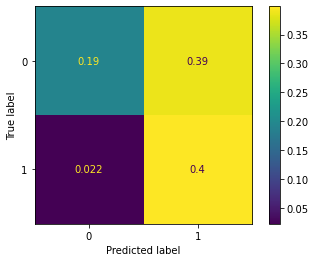

In [ ]:
with torch.no_grad():
    y_true, y_pred = predict_loader(train_dataloader)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0', '1'])
    disp.plot() 

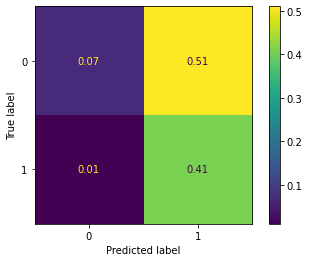

In [ ]:
with torch.no_grad():
    y_true, y_pred = predict_loader(val_dataloader)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0', '1'])
    disp.plot() 